# Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from skorch.callbacks import EarlyStopping, Checkpoint
import numpy as np
import torch
import torch.nn as nn
import os
import joblib
import matplotlib.pyplot as plt

from skorch import NeuralNetRegressor

## Configuration

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = Path('dataset')
data_name = "DS03"

## 1. Load dataset

In [3]:
df = pd.read_csv(dataset_path/f'dataset_{data_name}.csv',dtype={"Fc": str})
df

,index,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,...,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL,pos
0,0,3009.0,0.307251,81.122467,517.529644,623.26624,1504.1445,1922.4402,1306.5045,19.479847,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.000000
1,10,3097.0,0.313299,81.122467,517.592118,623.29270,1503.8613,1921.7820,1305.6849,19.463556,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.001764
2,20,3179.0,0.318969,81.122467,517.656203,623.32745,1503.6354,1921.2112,1304.9423,19.449510,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.003527
3,30,3260.0,0.323820,81.122467,517.677990,623.32950,1503.3647,1920.5135,1304.1140,19.431040,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.005291
4,40,3346.0,0.328608,80.946686,517.681309,623.12730,1502.3925,1918.7623,1302.8794,19.397814,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.007055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557126,5571235,3219.0,0.279090,31.113060,515.093744,571.86790,1285.6836,1547.1355,1158.2384,16.315649,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.992523
557127,5571245,3163.0,0.279216,31.113060,515.302046,572.10390,1286.1594,1547.6107,1158.6005,16.350014,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.994393
557128,5571255,3109.0,0.279972,31.113060,515.540115,572.35900,1286.6622,1548.2510,1159.0758,16.386671,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.996262
557129,5571265,3060.0,0.279594,31.113060,515.695979,572.53530,1287.0536,1548.7966,1159.5267,16.414255,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.998131


## Operation Condition Normalization Procedure

Learn $f: X\mapsto Y$ frp, the flight conditions $X$ to the sensor outputs/performance metrics $Y$

$X$ Consist of 6 features, 4 flight conditions, 
* flight mach number (mach)
* altitude (alt)
* throttle resolve angle (TRA) 
* total fan inlet temperature (T2)
* flight class, a categorical feature describing the  flight length(Fc)
* positional variable of time elapsed within the flight cycle (pos)

**Note:** The paper says 5 features but they enumerate 6. 

* Performance metrics: $T48$, $SmFan$, $SmLPC$, $SmHPC$

In [4]:
opcond_cols = ['alt', 'Mach', 'TRA', 'T2', 'Fc'] # , 'pos'
performance_cols = ['T48', 'SmFan','SmLPC','SmHPC']

### Get (healthy) operation conditions

In [5]:
df_healthy = df[df['hs'] == 1.0]
X_df= df_healthy[opcond_cols]
Y_df = df_healthy[performance_cols]

## Train

### MLP model

In [6]:
class OperatingConditionMLP(nn.Module):
    def __init__(self, input_dim,output_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),   # 14 sensor outputs
        )

    def forward(self, x):
        return self.net(x)

## Model

In [7]:
input_dim = len(opcond_cols) + df_healthy['Fc'].nunique()-1
output_dim = len(performance_cols)

callbacks = [
    EarlyStopping(
        monitor="valid_loss",
        patience=10,
        threshold=1e-4,
    ),
	Checkpoint(
    monitor="valid_loss_best",
    f_params="checkpoints/best_model.pt",
    f_optimizer="checkpoints/best_optimizer.pt",
    f_history="checkpoints/history.json",
)]

net = NeuralNetRegressor(
    OperatingConditionMLP,
    module__input_dim=input_dim,
    module__output_dim=output_dim,
    max_epochs=100,
    lr=5e-4,
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=device,
    callbacks=callbacks,
)


os.makedirs("checkpoints", exist_ok=True)

In [8]:
def to_float32(x: np.ndarray) -> np.ndarray:
    return x.astype(np.float32)

pipe = Pipeline([
    ("vec", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("to_float32", FunctionTransformer(to_float32)),
    ("mlp", net),
])
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vec', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"dtype dtype: dtype, default=np.float64The type of feature values. Passed to Numpy array/scipy.sparse matrixconstructors as the dtype argument.",<class 'numpy.float64'>
,"separator separator: str, default=""=""Separator string used when constructing new features for one-hotcoding.",'='
,"sparse sparse: bool, default=TrueWhether transform should produce scipy.sparse matrices.",False
,"sort sort: bool, default=TrueWhether ``feature_names_`` and ``vocabulary_`` should besorted when fitting.",True
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [9]:
X = X_df.to_dict(orient="records")
Y = Y_df.values.astype("float32")  
pipe.fit(X, Y)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1    76883.2108      619.2263     +  2.5592
      2      216.5652       97.5920     +  2.4963
      3       50.1018       33.4956     +  2.5076
      4       23.2306       19.6993     +  2.5765
      5       15.9618       15.6779     +  2.3231
      6       12.4324       11.6186     +  2.3828
      7        8.9142        6.7967     +  2.4309
      8        4.6181        3.3762     +  2.5067
      9        3.0282        2.6946     +  2.4893
     10        2.4952        2.4454     +  2.3860
     11        2.0360        1.7002     +  2.4445
     12        1.6520        2.1173        2.4919
     13        1.4879        1.3323     +  2.4795
     14        1.4054        1.1522     +  2.4793
     15        1.3093        1.4333        2.4803
     16        1.2826        1.2353        2.5333
     17        1.2377        1.0400     +  2.5512
     18        1.1568        1.5788        2.3506


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vec', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"dtype dtype: dtype, default=np.float64The type of feature values. Passed to Numpy array/scipy.sparse matrixconstructors as the dtype argument.",<class 'numpy.float64'>
,"separator separator: str, default=""=""Separator string used when constructing new features for one-hotcoding.",'='
,"sparse sparse: bool, default=TrueWhether transform should produce scipy.sparse matrices.",False
,"sort sort: bool, default=TrueWhether ``feature_names_`` and ``vocabulary_`` should besorted when fitting.",True
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


### Load the best parameters in the model pipeline

In [10]:
pipe.named_steps["mlp"].load_params(
    f_params="checkpoints/best_model.pt"
)

## Save the pipeline 

In [11]:
joblib.dump(pipe, "checkpoints/pipeline_best.joblib")

['checkpoints/pipeline_best.joblib']

## Load the pipeline

In [12]:
pipe_loaded = joblib.load("checkpoints/pipeline_best.joblib")

In [13]:
X_new = df[opcond_cols].to_dict(orient="records")
performance_new = pipe.predict(X_new)

In [14]:
performance_error = df[performance_cols] - performance_new
df_performance_error = pd.DataFrame(performance_error, columns=performance_cols)
df_performance_error['unit']= df['unit']
df_performance_error['cycle']= df['cycle']


In [15]:

df_performance_error

,T48,SmFan,SmLPC,SmHPC,unit,cycle
0,0.159194,0.825468,0.194795,-0.051659,1.0,1.0
1,-0.091901,0.773026,0.186679,-0.052139,1.0,1.0
2,-0.289532,0.723211,0.180747,-0.053224,1.0,1.0
3,-0.529225,0.684070,0.173182,-0.049341,1.0,1.0
4,-0.683257,0.632287,0.171908,-0.062450,1.0,1.0
...,...,...,...,...,...,...
557126,32.457521,-0.549406,-0.571898,-1.140438,9.0,84.0
557127,32.328718,-0.541485,-0.579628,-1.140292,9.0,84.0
557128,32.354027,-0.534861,-0.583631,-1.146585,9.0,84.0
557129,32.395721,-0.538665,-0.585966,-1.150710,9.0,84.0


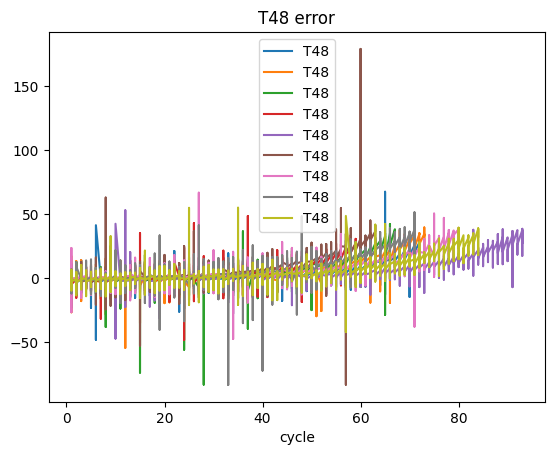

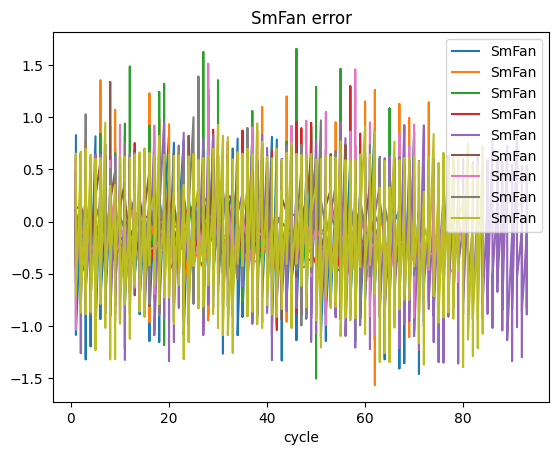

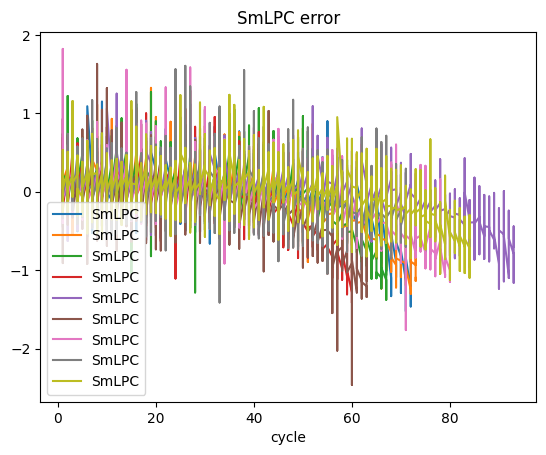

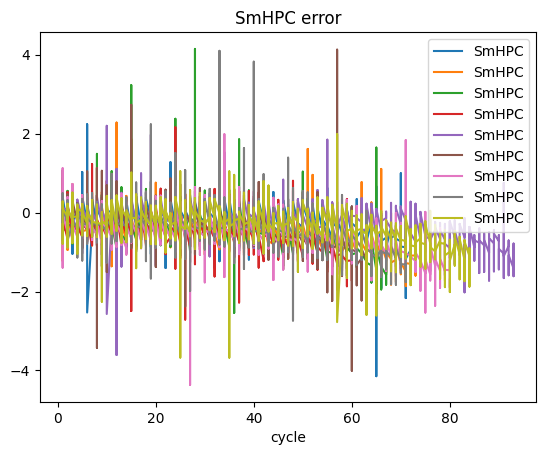

In [16]:
df_sel = df_performance_error[
    df_performance_error["unit"].isin(list(range(1,10)))
]


for perf in performance_cols:
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} error")
    df_sel.groupby("unit").plot(x="cycle", y=perf, ax=ax, legend=True)

In [26]:
df_performance_error['pos'] = 40*df['pos']

<Axes: xlabel='cycle'>

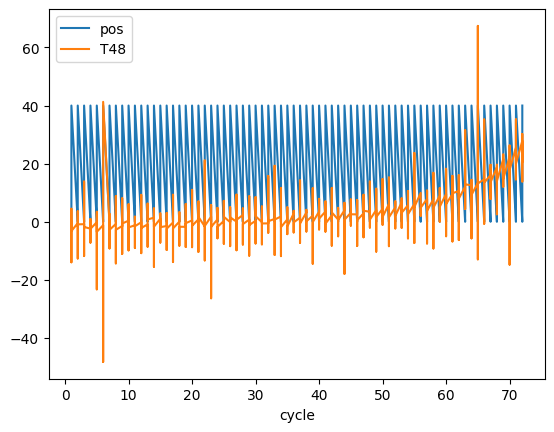

In [32]:
df_performance_error[(df['unit']==1)].plot(x='cycle', y=['pos', 'T48'])

In [35]:
df

,index,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,...,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL,pos
0,0,3009.0,0.307251,81.122467,517.529644,623.26624,1504.1445,1922.4402,1306.5045,19.479847,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.000000
1,10,3097.0,0.313299,81.122467,517.592118,623.29270,1503.8613,1921.7820,1305.6849,19.463556,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.001764
2,20,3179.0,0.318969,81.122467,517.656203,623.32745,1503.6354,1921.2112,1304.9423,19.449510,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.003527
3,30,3260.0,0.323820,81.122467,517.677990,623.32950,1503.3647,1920.5135,1304.1140,19.431040,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.005291
4,40,3346.0,0.328608,80.946686,517.681309,623.12730,1502.3925,1918.7623,1302.8794,19.397814,...,-0.000416,0.0,-0.000207,-0.000945,1.0,1.0,1,1.0,71.0,0.007055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557126,5571235,3219.0,0.279090,31.113060,515.093744,571.86790,1285.6836,1547.1355,1158.2384,16.315649,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.992523
557127,5571245,3163.0,0.279216,31.113060,515.302046,572.10390,1286.1594,1547.6107,1158.6005,16.350014,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.994393
557128,5571255,3109.0,0.279972,31.113060,515.540115,572.35900,1286.6622,1548.2510,1159.0758,16.386671,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.996262
557129,5571265,3060.0,0.279594,31.113060,515.695979,572.53530,1287.0536,1548.7966,1159.5267,16.414255,...,-0.012017,0.0,-0.008661,-0.007744,9.0,84.0,1,0.0,0.0,0.998131


<Axes: xlabel='cycle'>

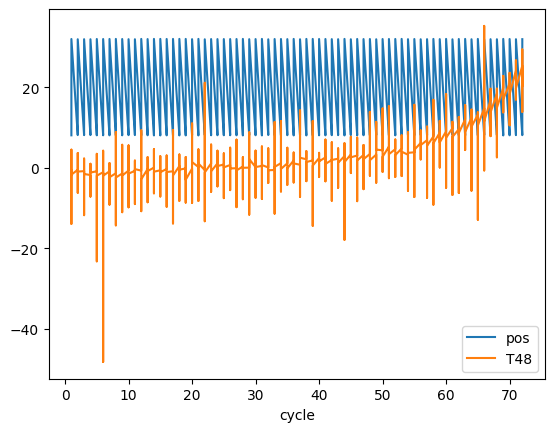

In [34]:
df_performance_error[(df['unit']==1)&(df['pos']<0.8)&(df['pos']>0.2)].plot(x='cycle', y=['pos', 'T48'])

unit
1.0    Axes(0.125,0.11;0.775x0.77)
2.0    Axes(0.125,0.11;0.775x0.77)
3.0    Axes(0.125,0.11;0.775x0.77)
4.0    Axes(0.125,0.11;0.775x0.77)
5.0    Axes(0.125,0.11;0.775x0.77)
6.0    Axes(0.125,0.11;0.775x0.77)
7.0    Axes(0.125,0.11;0.775x0.77)
8.0    Axes(0.125,0.11;0.775x0.77)
9.0    Axes(0.125,0.11;0.775x0.77)
dtype: object

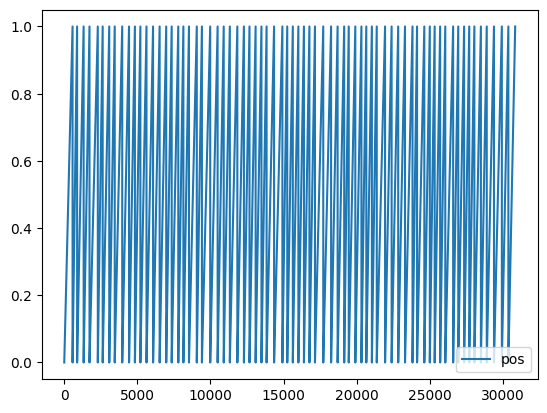

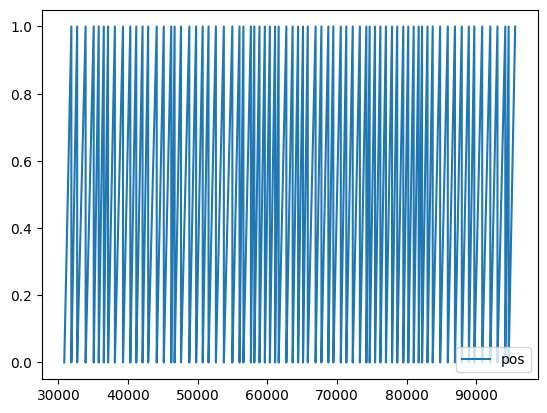

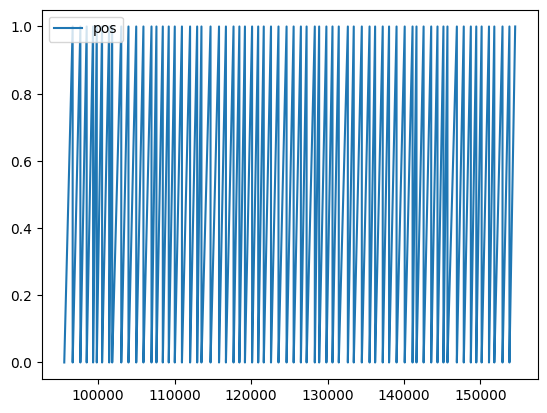

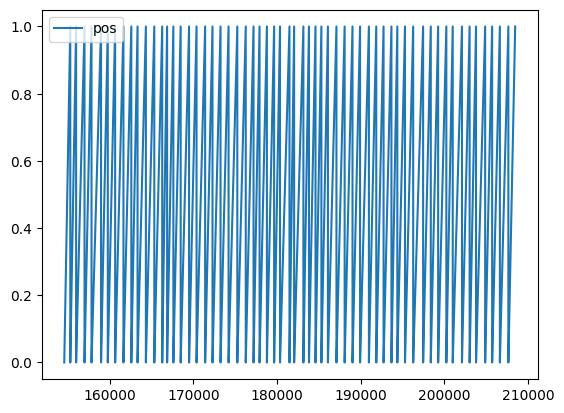

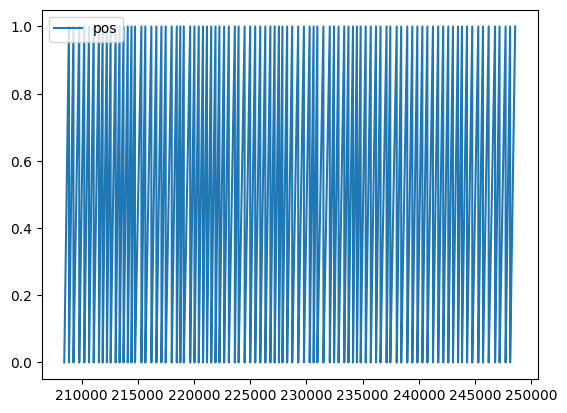

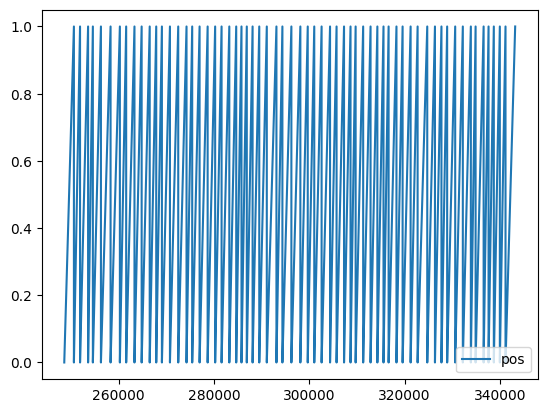

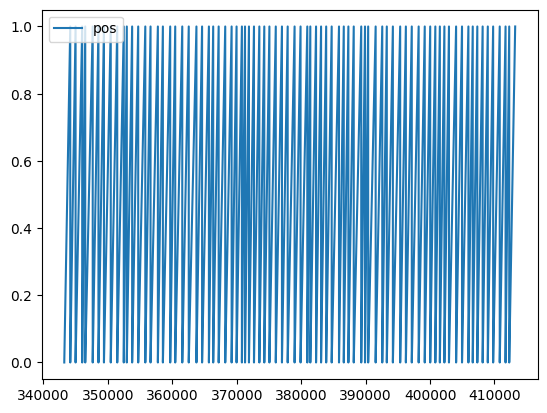

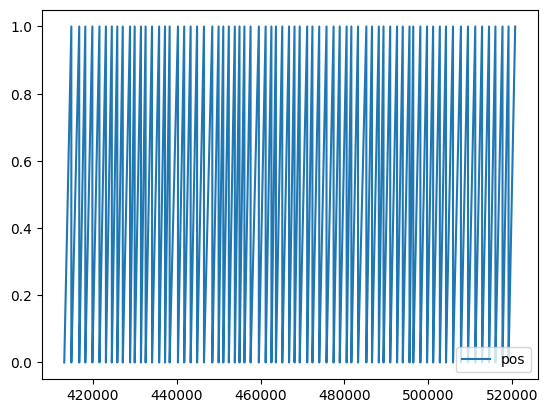

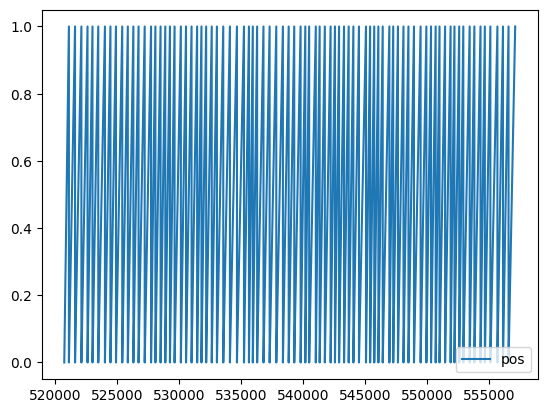

In [23]:
df.groupby('unit').plot(y="pos")

unit
1.0    Axes(0.125,0.11;0.775x0.77)
2.0    Axes(0.125,0.11;0.775x0.77)
3.0    Axes(0.125,0.11;0.775x0.77)
4.0    Axes(0.125,0.11;0.775x0.77)
5.0    Axes(0.125,0.11;0.775x0.77)
6.0    Axes(0.125,0.11;0.775x0.77)
7.0    Axes(0.125,0.11;0.775x0.77)
8.0    Axes(0.125,0.11;0.775x0.77)
9.0    Axes(0.125,0.11;0.775x0.77)
dtype: object

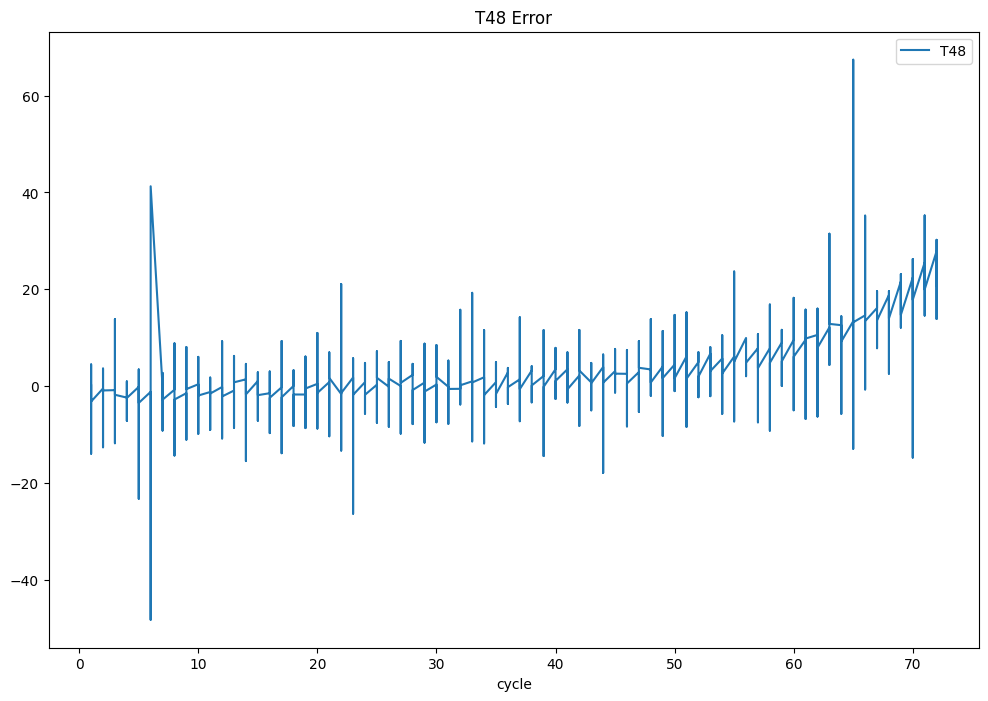

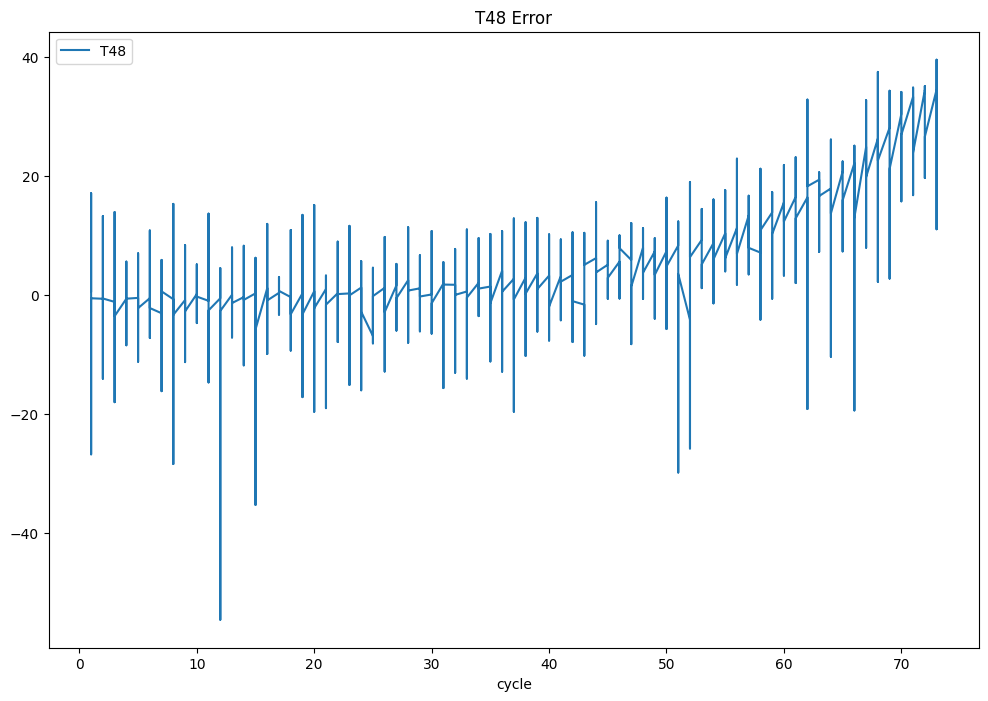

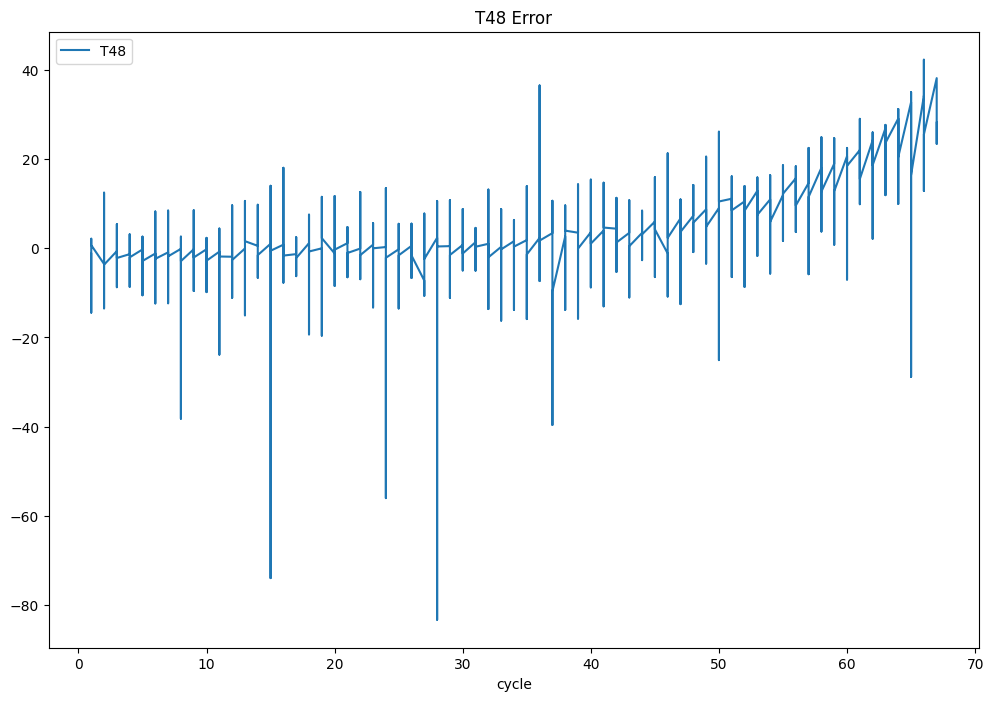

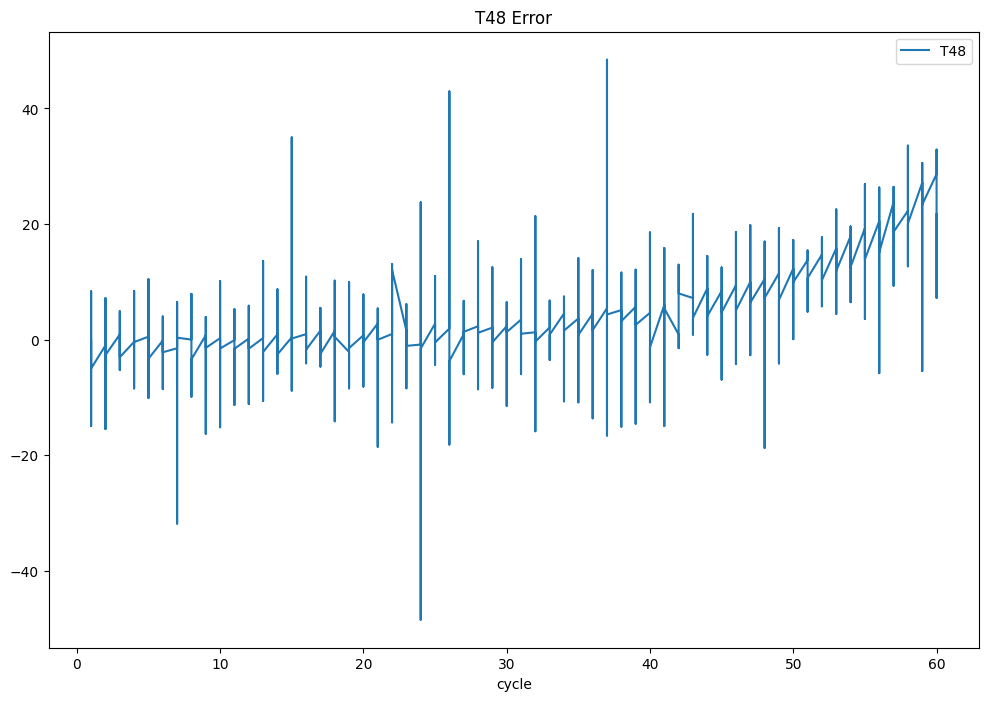

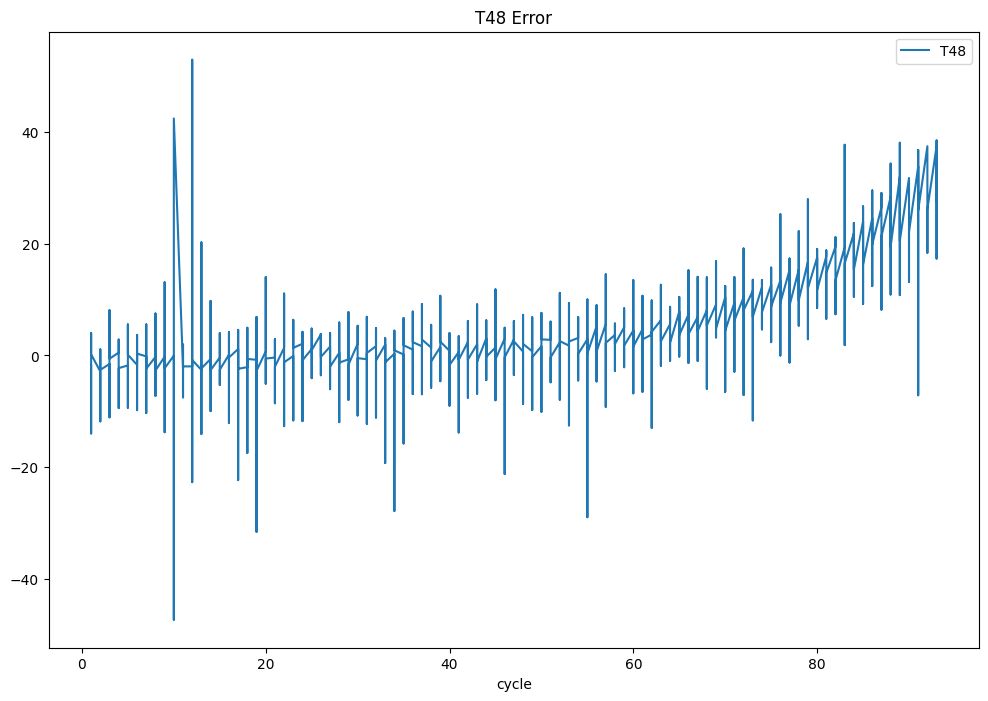

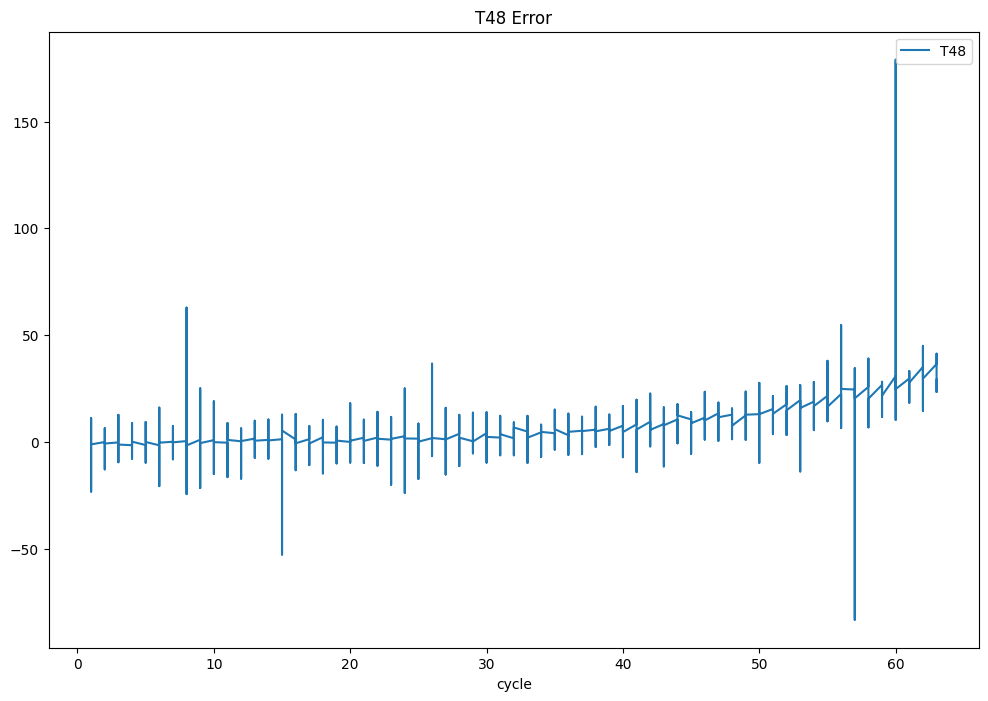

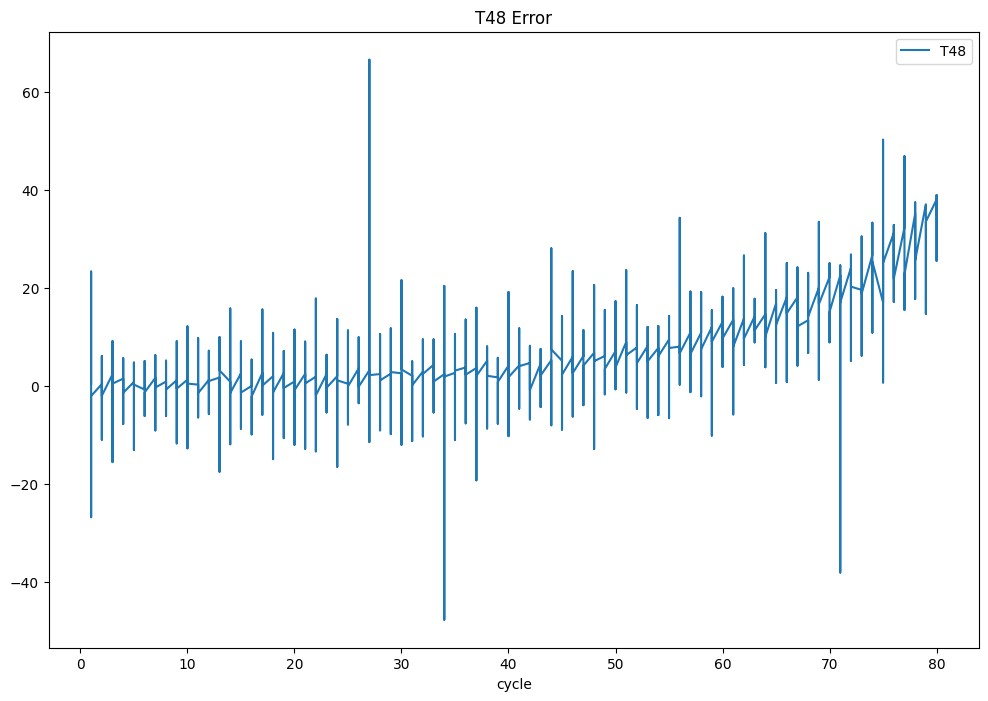

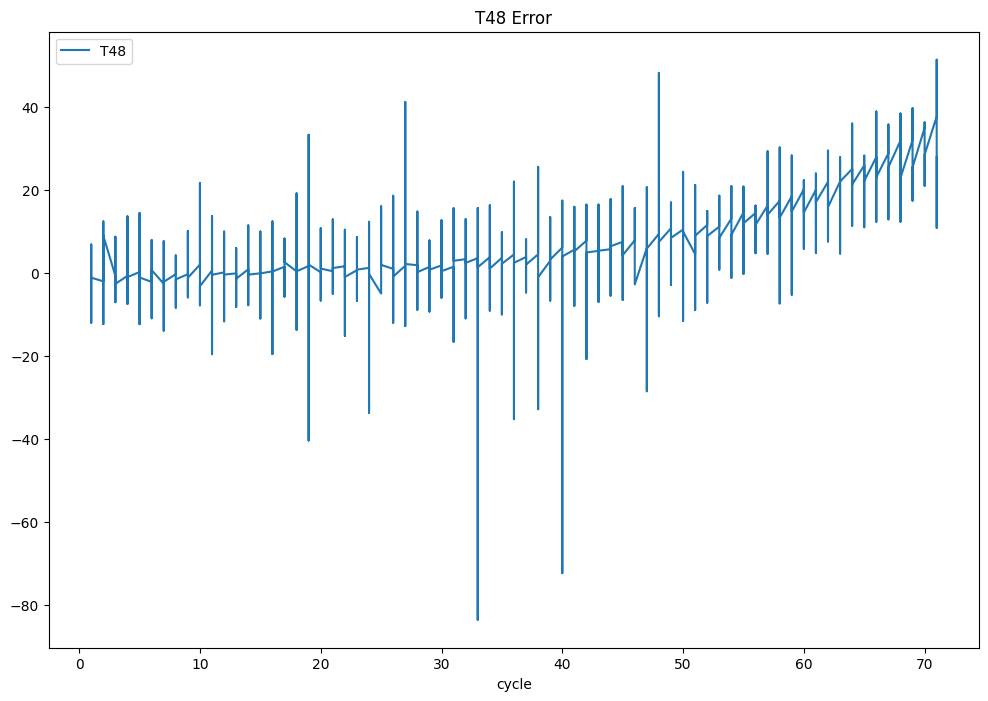

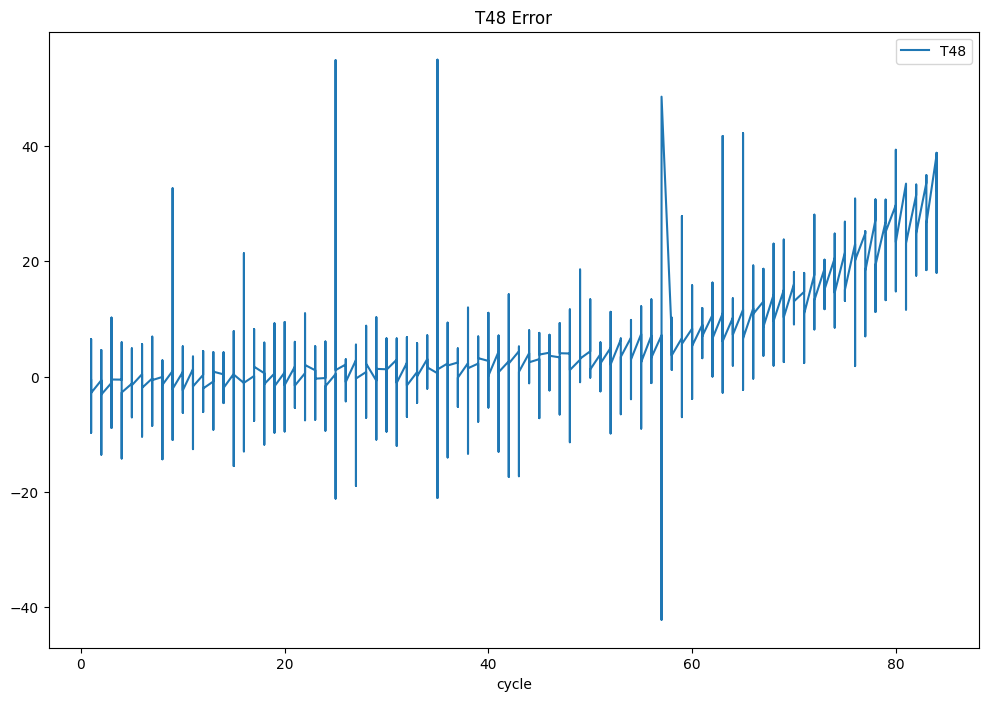

In [ ]:
df_performance_error.groupby("unit").plot(x="cycle",y="T48",title="T48 Error", figsize=(12, 8))